<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/2.%20Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Preparing data for model training and testing</p>
</div>

Raw tweet data is often noisy, inconsistent, and full of informal elements like emojis, mentions, hashtags, abbreviations, and inconsistent casing. Cleaning and standardizing this data is a critical step before any meaningful modeling can be done. Effective preprocessing not only improves model performance but also ensures that the insights learned from the data are robust and generalizable.

In this notebook, we apply a series of preprocessing steps tailored specifically to Twitter data, with the goal of simplifying the input while preserving sentiment-relevant patterns. The following steps will be applied to the Sentiment140 dataset:

- **Lowercasing** – Convert all text to lowercase to ensure consistency and reduce redundant token forms (e.g., "Happy" vs. "happy").
- **Mention, Hashtag & URL, HTML tags Handling** – Replace Twitter mentions (e.g., @username) with a generic token (`usermention`), remove URLs that typically do not contribute to sentiment, and normalize hashtags (e.g., `#happy` → `happy`), and remove HTML tags (e.g., `<b>great</b>`) to ensure clean, readable text.
- **Number and whitespace cleanup** – After token processing, remove excess spaces and strip leading/trailing whitespace.
- **Punctuation & Special Character Removal** – Remove common punctuation marks and special characters to simplify the token vocabulary and reduce noise.
- **Tokenization** – Split each tweet into a list of word tokens for structured processing in downstream models.
- **Lemmatization** – Reduce words to their dictionary (base) form to unify variations and decrease vocabulary size (e.g., "running" → "run").
- **Stopword Removal** – Filter out common stopwords (e.g., "and", "is") that carry little semantic weight, using an extended list that includes punctuation.
- **Empty Tweet Filtering** – Drop tweets that are empty after preprocessing to ensure that all inputs to the model are meaningful.

These steps help remove noise while preserving semantic structure, which is especially important for models like LSTM and BERT that are sensitive to input tokenization.

Finally, we will **split the dataset into training, validation and testing subsets** to evaluate the models' generalization performance on unseen data.

This preprocessing pipeline prepares our dataset for vectorization and embedding, enabling classical models like Logistic Regression as well as deep learning architectures to learn from tweet text effectively.

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Data Loading & Preprocessing</strong></h2>
  <p style="color:#333333;">Import Sentiment140 dataset and preprocess it with steps we already did during EDA.</p>
</div>


In [1]:
# Importing all libraries here
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import string
import sys
import os

In [2]:
# Import helper functions modularized from our EDA notebook
sys.path.append("../utils")
from helper import load_sentiment140, preprocess_raw_text_in_eda

In [3]:
# Step 1: Load Sentiment140 dataframe
df = load_sentiment140()

# Step 2: Preprocess raw text (decode, unescape HTML characters, remove empty rows, add length)
df = preprocess_raw_text_in_eda(df)

In [4]:
# Count how many tweets are longer than 140 characters
num_long_tweets = df[df['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 0


In [5]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1462693,"i am NOT liking the ""big-curly-hair-with-the-braids"" look :/ im not taking my braids out! i will just simply straighten my hair once more",138
1402277,Woke up to a storm outside...Florida gets on my nerves sometimes...the state not the lady from Good Times...except the episode when...nvm,138
1307540,"@ohmishka I thought it was such a great idea too, she said she would rather support independent artists than give her $ to big companies.",138
805844,"I like penis: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You know, it'.. http://tinyurl.com/d356b3",138
805840,"Selling DILDO in a box: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You.. http://tinyurl.com/ca2ecn",138
1111822,"http://twiturm.com/vew6 I made this mix just for fun. I used to live w/ 1 of the BCR (not as a bf) though in Lake Forest, CA. Trying ...",138
975039,"@chiropractic ha! you are my hero. weekend stats looking good over here, lots of people dreading their job come monday, searching 4 new 1",138
252190,Is finally back from London after being stuck in traffic for about 5 hours! I now have hardly any time to get work done. Long night ahead,138
626735,@brennygee Looks like the twitterverse disagrees with you I just figured my first iPod was white- I thought I'd be kicking it old school.,138
1307506,"yup its going to be @TaqiyyaLuvLa @10marion @officialTila @Tyrese4Real @Willie_Day26 @souljaboytellem and many more tonight,fun... lol jk",138


In [6]:
pd.reset_option('display.max_colwidth')

#### Data Loading and First Step Preprocessing Summary

From the above result, we confirm that the Sentiment140 dataset has been **successfully loaded and preprocessed** using the same steps developed during the EDA phase. 

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Steps: lowercasing, punctuation & stopword removal, tokenization, stemming, lemmatization, cleaning hashtags, mentions, URLs, numbers.</p>
</div>

In [7]:
# Download the stopwords, punkt and wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ariesslin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [8]:
#!python -m spacy download en_core_web_lg

try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    # Only download if the model is not already installed
    from spacy.cli import download
    download("en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")

In [9]:
# Load NLP model (includes word vectors and lemmatizer)
nlp = spacy.load('en_core_web_lg')

### Lowercasing

We lowercase all text to reduce redundancy — for example, "Happy" and "happy" should be treated the same. This standardization helps models treat words as case-insensitive unless case carries specific meaning (which it usually doesn't in tweets).

In [10]:
# Create a clean copy of relevant columns
tweets = df.loc[:, ['text', 'target']].copy()

# Apply lowercase
tweets['text'] = tweets['text'].str.lower()
tweets.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


### Replace Mentions, Hashtags and Remove URLs, HTML tags

We replace Twitter mentions (e.g., @elonmusk) with a generic token (`usermention`), remove URLs which typically do not carry sentiment information and introduce noise, and strip hashtags (e.g., `#happy` → `happy`) so the keyword remains useful for modeling. This helps clean the data while preserving tweet structure and retaining emotionally relevant content.

In [11]:
# Replace all @mentions with "usermention"
tweets['text'] = tweets['text'].str.replace(r'@\w+', 'usermention ', regex=True)

# Remove '#' from hashtags but keep the word
tweets['text'] = tweets['text'].str.replace(r'#', '', regex=True)

# Remove URLs
tweets['text'] = tweets['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

# Remove html tags
tweets['text'] = tweets['text'].str.replace(r'<.*?>', '', regex=True)

tweets.head()

,text,target
0,usermention - a that's a bummer. you should...,0
1,is upset that he can't update his facebook by ...,0
2,usermention i dived many times for the ball. ...,0
3,my whole body feels itchy and like its on fire,0
4,"usermention no, it's not behaving at all. i'm...",0


#### Why We Keep the 'usermention' Token

Instead of removing user mentions entirely (e.g., `@elonmusk`), we replace them with a generic placeholder token: `usermention`. This preserves the fact that the tweet is directed at someone, which can carry important sentiment signals.

For example:
- `"usermention you are amazing!"` likely expresses positive sentiment toward someone
- `"usermention this is terrible"` may reflect negative sentiment or a complaint

By standardizing all mentions to a single token:
- We remove identity-specific noise (e.g., usernames)
- We retain structural and emotional intent, especially useful for models like **Logistic Regression**, **LSTM**, and **BERT**, which can learn patterns involving direct address

This token helps the model distinguish between general statements and targeted expressions — often a subtle but meaningful difference in sentiment classification.

### Number and Whitespace Cleanup

We remove numeric digits from tweets to prevent potential noise from irrelevant numbers (e.g., user IDs, dates, counts). Then we normalize whitespace by converting multiple consecutive spaces into a single space and trimming leading/trailing whitespace. This ensures clean, consistent input formatting for the model.

In [12]:
def clean_numbers_and_whitespace(text):
    # Remove digits
    text = ''.join(char for char in text if not char.isdigit())
    # Normalize whitespace
    return ' '.join(text.split())

tweets['text'] = tweets['text'].apply(clean_numbers_and_whitespace)

tweets.head()

,text,target
0,usermention - a that's a bummer. you shoulda g...,0
1,is upset that he can't update his facebook by ...,0
2,usermention i dived many times for the ball. m...,0
3,my whole body feels itchy and like its on fire,0
4,"usermention no, it's not behaving at all. i'm ...",0


### Punctuation & Special Character Removal

We remove standard punctuation symbols (e.g., `.`, `,`, `!`, `?`) to reduce vocabulary noise and standardize tokens. This step helps models focus on the core semantic content of tweets rather than stylistic or formatting variations.

In [13]:
punctuation_pattern = r'[{}]'.format(re.escape(string.punctuation))

# Remove punctuation
tweets['text'] = tweets['text'].str.replace(punctuation_pattern, '', regex=True)

# Remove special characters (keep only letters, digits, and whitespace)
tweets['text'] = tweets['text'].str.replace(r'[^\w\s]', '', regex=True)

tweets.head()

,text,target
0,usermention a thats a bummer you shoulda got ...,0
1,is upset that he cant update his facebook by t...,0
2,usermention i dived many times for the ball ma...,0
3,my whole body feels itchy and like its on fire,0
4,usermention no its not behaving at all im mad ...,0


### Tokenization

Before removing stopwords, we tokenize each tweet into individual words. This allows us to filter out unwanted tokens and prepare the data for model ingestion. We use `nltk.word_tokenize()` for consistent, linguistically aware token boundaries.

In [14]:
tokenizer = TreebankWordTokenizer()

# Tokenize tweets
tweets['tokens'] = tweets['text'].apply(tokenizer.tokenize)

tweets.head()

,text,target,tokens
0,usermention a thats a bummer you shoulda got ...,0,"[usermention, a, thats, a, bummer, you, should..."
1,is upset that he cant update his facebook by t...,0,"[is, upset, that, he, cant, update, his, faceb..."
2,usermention i dived many times for the ball ma...,0,"[usermention, i, dived, many, times, for, the,..."
3,my whole body feels itchy and like its on fire,0,"[my, whole, body, feels, itchy, and, like, its..."
4,usermention no its not behaving at all im mad ...,0,"[usermention, no, its, not, behaving, at, all,..."


### Lemmatization

Lemmatization converts each word to its base form — e.g., "running" → "run". This reduces the total number of unique tokens and helps models generalize across word variations without losing semantic meaning.

In [15]:
# Lemmatizers
lemmatizer = WordNetLemmatizer()

# WordNetLemmatizer defaults to noun if we don’t tell it the POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # fallback

# Lemmatize each token except 'usermention'
def lemmatize_tokens(tokens):
    tagged = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) if word != 'usermention' else word
        for word, tag in tagged
    ]

# Apply to the 'tokens' column
tweets['tokens'] = tweets['tokens'].apply(lemmatize_tokens)

# Rejoin back into cleaned text
tweets['text'] = tweets['tokens'].apply(lambda x: ' '.join(x))

tweets.head()

,text,target,tokens
0,usermention a thats a bummer you shoulda get d...,0,"[usermention, a, thats, a, bummer, you, should..."
1,be upset that he cant update his facebook by t...,0,"[be, upset, that, he, cant, update, his, faceb..."
2,usermention i dive many time for the ball mana...,0,"[usermention, i, dive, many, time, for, the, b..."
3,my whole body feel itchy and like it on fire,0,"[my, whole, body, feel, itchy, and, like, it, ..."
4,usermention no it not behave at all im mad why...,0,"[usermention, no, it, not, behave, at, all, im..."


#### Why We Use Lemmatization Instead of Stemming

Although stemming (e.g., using `PorterStemmer`) is a common text preprocessing step, we chose **lemmatization** here because it retains more accurate and interpretable base forms of words. For example, lemmatization correctly maps:

- "running" → "run"
- "better" → "good"

Whereas stemming would incorrectly output:

- "running" → "run"
- "better" → "bett"

This distinction is important for our models:

- **Logistic Regression (TF-IDF)**: Lemmatization improves generalization while preserving word meaning.
- **LSTM**: Sequence models benefit from accurate word forms to capture semantic structure.
- **BERT**: Already handles word variations internally (via subword tokenization), but providing cleaner input can still help.

Thus, lemmatization is the better choice for our pipeline, and stemming was deliberately excluded.

### Stopword Removal

Stopwords are very common words (like "the", "and", "is") that generally carry little semantic meaning in text classification. Removing them helps focus on words with stronger sentiment signal. We apply this step using a vectorized approach across all tweets to improve efficiency. The stopword list is extended to also remove punctuation and common social media symbols.

In [16]:
stop_words = set(stopwords.words('english'))

# Add extra symbols to stop words
stop_words.update(string.punctuation)
stop_words.update(["''", "'", '``', '’', '“', '”','–', '—', '…', '..', '.', ',', ':', ';', '?', '!', '(', ')', '[', ']', '{', '}', '/', '|'])

In [17]:
# Remove stopwords but keep 'usermention'
tweets['tokens'] = tweets['tokens'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words or word == 'usermention']
)

# Rejoin tokens to text for downstream models
tweets['text'] = tweets['tokens'].apply(lambda x: ' '.join(x))

tweets.head()

,text,target,tokens
0,usermention thats bummer shoulda get david car...,0,"[usermention, thats, bummer, shoulda, get, dav..."
1,upset cant update facebook texting might cry r...,0,"[upset, cant, update, facebook, texting, might..."
2,usermention dive many time ball manage save re...,0,"[usermention, dive, many, time, ball, manage, ..."
3,whole body feel itchy like fire,0,"[whole, body, feel, itchy, like, fire]"
4,usermention behave im mad cant see,0,"[usermention, behave, im, mad, cant, see]"


#### Why We Extend the Stopword List with Punctuation and Special Symbols

Although we remove most punctuation at the raw text level using string replacement, some unwanted characters and symbols can still survive into the tokenized text. This is especially true for:

- Unicode punctuation (e.g., smart quotes `“ ”`, apostrophes `’`, ellipses `…`)
- Duplicate or broken punctuation (e.g., `..`, `...`)
- Special characters not included in `string.punctuation` (e.g., `{}`, `[]`, `|`)
- Symbols that may be split as tokens by the tokenizer (e.g., `(`, `)`, `/`, `|`)

To ensure we clean these up consistently, we **extend the stopword list** with both:
- The built-in `string.punctuation`, and
- A custom list of additional noisy tokens that frequently appear in tweets

This helps reduce vocabulary noise, avoid irrelevant tokens in our models, and ensures that even after tokenization, our data remains clean and focused on meaningful words.

In [18]:
tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

540

In [19]:
# Take only columns with features and labels
preprocessed_tweets = tweets.loc[:, ['text', 'target']].copy()
preprocessed_tweets.head()

,text,target
0,usermention thats bummer shoulda get david car...,0
1,upset cant update facebook texting might cry r...,0
2,usermention dive many time ball manage save re...,0
3,whole body feel itchy like fire,0
4,usermention behave im mad cant see,0


In [20]:
preprocessed_tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

540

**we have around 500 "new" null text cells introduced after removing stop words. they will be deleted later as a first step before sampling training, validation and testing data**

#### Here we view word cloud of tweets for negative and positive marks

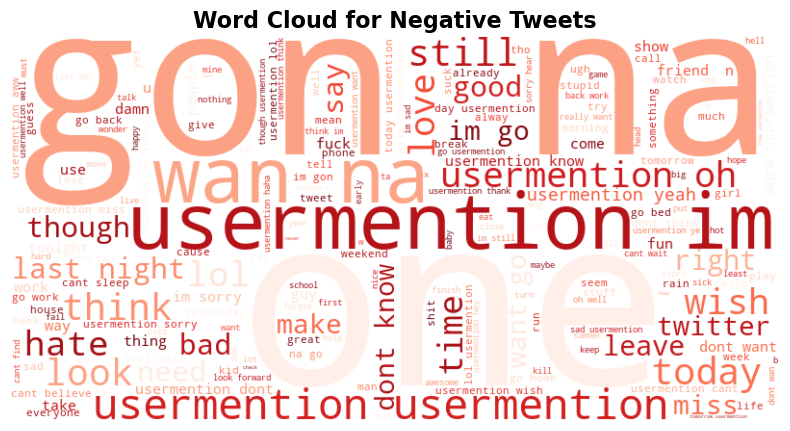

In [21]:
# Negative Tweets word cloud

# Filter only negative tweets (target == 0)
negative_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 0]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(negative_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Tweets", fontsize=16, fontweight='bold')
plt.show()

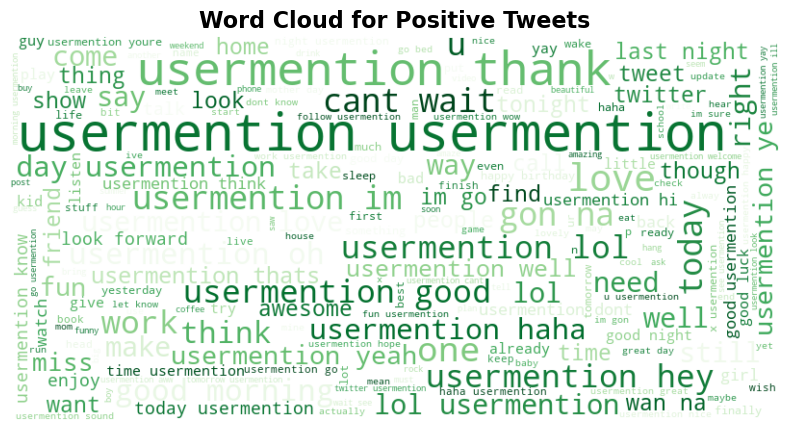

In [22]:
# Positive Tweets word cloud

# Filter only positive tweets (target == 4)
positive_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 4]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(positive_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Tweets", fontsize=16, fontweight='bold')
plt.show()

In [23]:
# We now save the processed tweets to be used later in model development

processed_data_dir = "../processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

output_processed_file_path = os.path.join(processed_data_dir, "preprocessed_tweets.csv")
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

Preprocessed tweets saved to: ../processed_data/preprocessed_tweets.csv


#### Next we take first 70% of each negative and positive tweets for training, 15% for validation, and 15% for testing.
Sampling sould be done in a way that respects tweets length distribution.

This way we make sure all models are trained and validated using the same dataset and we have a good ground for fair comparison.

This step is valid because we showed in EDA section that negative and positive tewwts are equally distributed.

In [24]:
# Here, we begin by loading the processed dataset and assign column names

preprocessed_path = "../processed_data/preprocessed_tweets.csv"
Tweets = pd.read_csv(preprocessed_path, header=None, names=["text", "target"])

# Read the preprocessed tweet dataset and assign column names
# Tweets = pd.read_csv("../data/preprocessed_tweets.csv", header=None, names=["text", "target"])

# Drop any rows where 'text' or 'target' is null
Tweets = Tweets.dropna(subset=["text", "target"])

Tweets.head()

/var/folders/5m/q16b86r92zgbmjpxpdx4ghfw0000gn/T/ipykernel_20893/2734645548.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  Tweets = pd.read_csv(preprocessed_path, header=None, names=["text", "target"])


,text,target
0,text,target
1,usermention thats bummer shoulda get david car...,0
2,upset cant update facebook texting might cry r...,0
3,usermention dive many time ball manage save re...,0
4,whole body feel itchy like fire,0


In [25]:
# Define bins and labels from the bar chart in our EDA
bin_edges = [0, 20, 40, 60, 80, 100, 120, 140]
bin_labels = ['0–20', '21–40', '41–60', '61–80', '81–100', '101–120', '121–140']

# Step 1: Assign length buckets safely
def assign_length_buckets(df):
    df = df.copy()
    df['text'] = df['text'].fillna('').astype(str)  # Ensure no NaNs
    df['text_length'] = df['text'].str.len()
    df['length_bucket'] = pd.cut(
        df['text_length'],
        bins=bin_edges,
        labels=bin_labels,
        right=True,
        include_lowest=True
    )
    df = df.dropna(subset=['length_bucket'])  # Drop any that didn't fall in bin
    return df

# Step 2: Stratified split function
def stratified_split_by_length_bucket(df_class, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    df_class = assign_length_buckets(df_class)

    # Split into train and temp
    train_df, temp_df = train_test_split(
        df_class,
        test_size=1 - train_ratio,
        stratify=df_class['length_bucket'],
        random_state=42
    )

    # Split temp into validation and test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=1 - val_ratio_adjusted,
        stratify=temp_df['length_bucket'],
        random_state=42
    )

    return train_df.drop(columns='length_bucket'), val_df.drop(columns='length_bucket'), test_df.drop(columns='length_bucket')

# Step 3: Filter by sentiment
df_neg = Tweets[Tweets['target'] == 0]
df_pos = Tweets[Tweets['target'] == 4]

# Step 4: Apply stratified splitting
neg_train, neg_val, neg_test = stratified_split_by_length_bucket(df_neg)
pos_train, pos_val, pos_test = stratified_split_by_length_bucket(df_pos)

# Step 5: Combine and shuffle
train_df = pd.concat([neg_train, pos_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([neg_val, pos_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([neg_test, pos_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Extract input and labels
X_train = train_df['text']
y_train = train_df['target']
X_val = val_df['text']
y_val = val_df['target']
X_test = test_df['text']
y_test = test_df['target']

# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "| y_test shape:", y_test.shape)

Train shape: (936165, 3)
Validation shape: (200607, 3)
Test shape: (200609, 3)
X_train shape: (936165,) | y_train shape: (936165,)
X_val shape: (200607,) | y_val shape: (200607,)
X_test shape: (200609,) | y_test shape: (200609,)


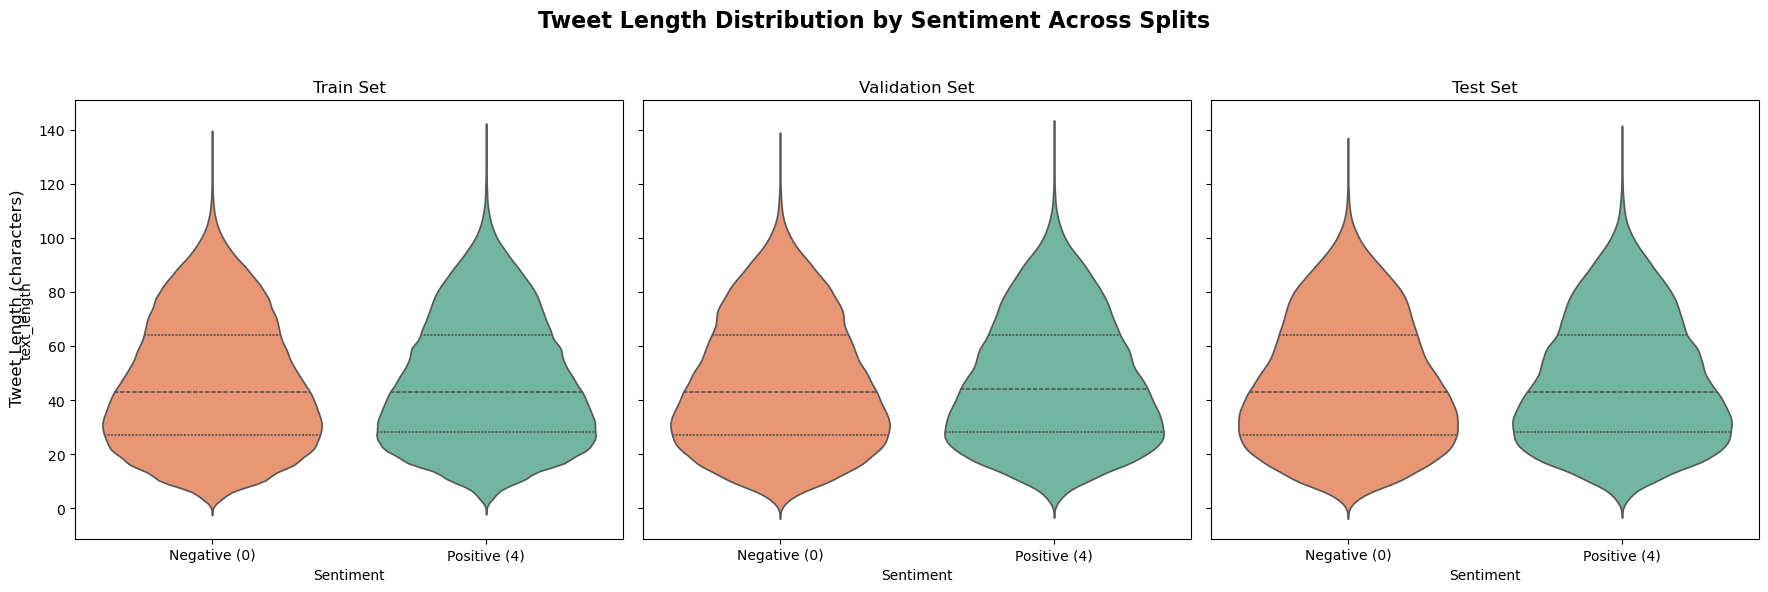

In [26]:
# here we validate the distributions are identical and intact

# Combine text + label for plotting, and calculate text length
train_plot_df = pd.concat([X_train, y_train], axis=1).copy()
val_plot_df = pd.concat([X_val, y_val], axis=1).copy()
test_plot_df = pd.concat([X_test, y_test], axis=1).copy()

# Ensure text_length column is present
train_plot_df['text_length'] = train_plot_df['text'].str.len()
val_plot_df['text_length'] = val_plot_df['text'].str.len()
test_plot_df['text_length'] = test_plot_df['text'].str.len()

# Ensure 'target' is integer (not string) for palette mapping
train_plot_df['target'] = train_plot_df['target'].astype(int)
val_plot_df['target'] = val_plot_df['target'].astype(int)
test_plot_df['target'] = test_plot_df['target'].astype(int)

# Define sentiment color palette
sentiment_palette = {
    0: '#fc8d62',  # Negative
    4: '#66c2a5'   # Positive
}

# Set up subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot train
sns.violinplot(ax=axes[0], data=train_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[0].set_title('Train Set')
axes[0].set_xlabel('Sentiment')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot validation
sns.violinplot(ax=axes[1], data=val_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Sentiment')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot test
sns.violinplot(ax=axes[2], data=test_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[2].set_title('Test Set')
axes[2].set_xlabel('Sentiment')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Shared Y-label and layout
fig.supylabel('Tweet Length (characters)', fontsize=12)
plt.suptitle("Tweet Length Distribution by Sentiment Across Splits", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

After we made sure we have good and valid splits, we now move on to modeling part, where we will only use training and validation set for model comparison and selection, ***testing dataset will only be used in model performance evaluation section***

In [27]:
# Finally, we save splits as CSV to ensure no data leakage takes place as differnt team members split and train the models. this way everyone uses the same training dataset.

import zipfile

# Set this to True if running in Google Colab
USE_COLAB = False

# Define save path
processed_data_dir = "../processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

# File paths
train_path = os.path.join(processed_data_dir, "train_dataset.csv")
val_path = os.path.join(processed_data_dir, "val_dataset.csv")
test_path = os.path.join(processed_data_dir, "test_dataset.csv")

# Save split datasets
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)
print("Local files saved.")

# Optional: Save as zip archive
if USE_COLAB:
    zip_path = os.path.join(processed_data_dir, "sentiment140_splits.zip")
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(train_path, arcname="train_dataset.csv")
        zipf.write(val_path, arcname="val_dataset.csv")
        zipf.write(test_path, arcname="test_dataset.csv")

    print(f"✅ Datasets saved to: {processed_data_dir}")
    print(f"📦 Zipped archive saved to: {zip_path}")

# Optional: download in Colab
if USE_COLAB:
    try:
        from google.colab import files
        files.download(train_path)
        files.download(val_path)
        files.download(test_path)
        files.download(zip_path)
    except ImportError:
        print("Google Colab download skipped — not running in Colab.")

    print("\n📦 Ready to commit the archive to your GitHub repository:")
    print(f"cd to repo folder and run:\n")
    print(f"git add {zip_path}")
    print(f'git commit -m "Add compressed dataset splits for reproducibility"')
    print("git push")

Local files saved.
